In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.vae import CrossSpeciesVAE, DivergenceEarlyStopping
from src.data import CrossSpeciesDataModule

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

In [2]:
# First collect and process EggNOG data as before
dfs = []
for f in glob(eggnogs):
    dfs.append(pd.read_csv(f,sep='\t',header=None,skiprows=1))
df = pd.concat(dfs,axis=0)

# Create species-specific gene to OG mappings
species_gene_ogs = {
    "planarian": {},
    "schisto": {},
    "hydra": {}
}

# Map genes to species using your AnnData objects
species_genes = {
    "planarian": set(adata1.var_names),
    "schisto": set(adata2.var_names),
    "hydra": set(adata3.var_names)
}

# Create OG mappings for each species
ogs = set()
for i in df[18].values:
    for j in i.split(','):
        ogs.add(j)
ogs = list(ogs)

# Create gene to OG mapping for each species
for species_name, genes in species_genes.items():
    species_df = df[df.iloc[:,0].isin(genes)]
    ogs_per_gene = [i.split(',') for i in species_df[18].values]
    genes = species_df.iloc[:,0].values
    species_gene_ogs[species_name] = dict(zip(genes, ogs_per_gene))

# Create nested dictionary for homology edges and scores
homology_edges = {}
homology_scores = {}

# Initialize nested dictionaries
species_ids = {name: idx for idx, name in enumerate(species_genes.keys())}
for src_id in species_ids.values():
    homology_edges[src_id] = {}
    homology_scores[src_id] = {}

# Create edges for each species pair
for src_species, src_id in species_ids.items():
    for dst_species, dst_id in species_ids.items():
        if src_species == dst_species:
            continue
            
        # Create gene-OG matrices for both species
        src_genes = list(species_gene_ogs[src_species].keys())
        dst_genes = list(species_gene_ogs[dst_species].keys())
        
        indexer = pd.Series(index=ogs, data=range(len(ogs)))
        
        # Source species matrix
        x_src, y_src, z_src = [], [], []
        for i, g in enumerate(src_genes):
            if g in species_gene_ogs[src_species]:
                v = indexer[species_gene_ogs[src_species][g]].values
                x_src.extend([i]*len(v))
                y_src.extend(v)
                z_src.extend(np.ones_like(v))
        
        # Destination species matrix
        x_dst, y_dst, z_dst = [], [], []
        for i, g in enumerate(dst_genes):
            if g in species_gene_ogs[dst_species]:
                v = indexer[species_gene_ogs[dst_species][g]].values
                x_dst.extend([i]*len(v))
                y_dst.extend(v)
                z_dst.extend(np.ones_like(v))
        
        # Create sparse matrices
        src_matrix = sp.sparse.coo_matrix(
            (z_src, (x_src, y_src)),
            shape=(len(src_genes), len(ogs))
        )
        dst_matrix = sp.sparse.coo_matrix(
            (z_dst, (x_dst, y_dst)),
            shape=(len(dst_genes), len(ogs))
        )
        
        # Compute similarity graph
        similarity = src_matrix.dot(dst_matrix.T)
        
        # Get edges and scores
        src_idx, dst_idx = similarity.nonzero()
        scores = similarity.data
        
        # Filter by minimum score
        filt = scores > 0
        edges = torch.tensor(np.vstack((src_idx, dst_idx)).T)[filt]
        edge_scores = torch.tensor(scores)[filt]
        
        # Store in nested dictionaries
        homology_edges[src_id][dst_id] = edges
        homology_scores[src_id][dst_id] = edge_scores

In [3]:
batch_size = 32

# First, let the data module setup
data_module = CrossSpeciesDataModule(
    species_data = {
        "planarian": adata1,
        "schisto": adata2,
        "hydra": adata3,
    },
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0
)
data_module.setup()

# Get species vocabulary sizes from data module
species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=0.1,
    species_embedding_dim=32,
    init_beta=1e-3,
    final_beta=0.1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    homology_weight=0.0,
    init_cross_species_weight = 0.0,
    final_cross_species_weight = 0.0,
    stage_transition_epoch = 0.0,   
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=100,
    verbose=True,
    mode='min'
)

# divergence_stopping = DivergenceEarlyStopping(
#     monitor='loss',
#     divergence_threshold=0.1,  # Stop if val_loss is 10% higher than train_loss
#     check_divergence_after=750,  # Start checking after 500 steps
# )

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=75,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        monitor="val_loss",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=len(species_vocab_sizes),  # Number of species
    enable_progress_bar=True,
    fast_dev_run=False,
)

Scaled learning rate: 1.00e-03


Using 16bit Automatic Mixed Precision (AMP)
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type          | Params | Mode 
--------------------------------------------------------------------
0 | mu_layer                  | Linear        | 20.6 K | train
1 | logvar_layer              | Linear        | 20.6 K | train
2 | encoder_species_embedding | Embedding     | 96     | train

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]Warmup steps calculated: 8
Epoch 0: 100%|██████████| 81/81 [00:03<00:00, 22.07it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 81/81 [00:03<00:00, 20.84it/s, v_num=304]     

Metric val_loss improved. New best score: 0.736


Epoch 1: 100%|██████████| 81/81 [00:03<00:00, 22.49it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 81/81 [00:03<00:00, 21.49it/s, v_num=304]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 81/81 [00:03<00:00, 20.28it/s, v_num=304]     

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.727


Epoch 3: 100%|██████████| 81/81 [00:03<00:00, 22.46it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 81/81 [00:03<00:00, 21.19it/s, v_num=304]     

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.721


Epoch 4: 100%|██████████| 81/81 [00:03<00:00, 21.92it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 81/81 [00:03<00:00, 20.69it/s, v_num=304]     

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.717


Epoch 5: 100%|██████████| 81/81 [00:03<00:00, 21.33it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 81/81 [00:04<00:00, 20.20it/s, v_num=304]     

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.708


Epoch 6: 100%|██████████| 81/81 [00:03<00:00, 21.40it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 81/81 [00:03<00:00, 22.03it/s, v_num=304]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 81/81 [00:03<00:00, 22.34it/s, v_num=304]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 81/81 [00:03<00:00, 21.07it/s, v_num=304]     

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.708


Epoch 9: 100%|██████████| 81/81 [00:03<00:00, 21.80it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 81/81 [00:03<00:00, 22.18it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 81/81 [00:03<00:00, 20.91it/s, v_num=304]    

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.707


Epoch 11: 100%|██████████| 81/81 [00:03<00:00, 21.92it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 81/81 [00:03<00:00, 21.96it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 81/81 [00:03<00:00, 20.75it/s, v_num=304]    

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.702


Epoch 13: 100%|██████████| 81/81 [00:03<00:00, 21.61it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 81/81 [00:03<00:00, 20.40it/s, v_num=304]    

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.700


Epoch 14: 100%|██████████| 81/81 [00:03<00:00, 20.97it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 81/81 [00:03<00:00, 22.15it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 81/81 [00:03<00:00, 21.89it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 81/81 [00:03<00:00, 22.04it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 81/81 [00:03<00:00, 22.21it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 81/81 [00:03<00:00, 21.68it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 81/81 [00:03<00:00, 20.47it/s, v_num=304]    

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.698


Epoch 20: 100%|██████████| 81/81 [00:03<00:00, 21.67it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 81/81 [00:03<00:00, 22.41it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 81/81 [00:03<00:00, 22.33it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 81/81 [00:03<00:00, 22.34it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 81/81 [00:03<00:00, 22.19it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 81/81 [00:03<00:00, 21.92it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 81/81 [00:03<00:00, 21.51it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 81/81 [00:03<00:00, 21.38it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 81/81 [00:04<00:00, 20.19

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.697


Epoch 28: 100%|██████████| 81/81 [00:03<00:00, 21.16it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 81/81 [00:03<00:00, 22.35it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 81/81 [00:03<00:00, 22.89it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 81/81 [00:03<00:00, 23.29it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 81/81 [00:03<00:00, 21.92it/s, v_num=304]    

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.696


Epoch 32: 100%|██████████| 81/81 [00:03<00:00, 22.83it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 81/81 [00:03<00:00, 22.58it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 81/81 [00:03<00:00, 22.18it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 81/81 [00:03<00:00, 20.94it/s, v_num=304]    

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.695


Epoch 35: 100%|██████████| 81/81 [00:03<00:00, 22.50it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 81/81 [00:03<00:00, 22.63it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 81/81 [00:03<00:00, 22.80it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 81/81 [00:03<00:00, 22.63it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 81/81 [00:03<00:00, 22.58it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 81/81 [00:03<00:00, 21.27it/s, v_num=304]    

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.695


Epoch 40: 100%|██████████| 81/81 [00:03<00:00, 22.79it/s, v_num=304]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 81/81 [00:03<00:00, 22.69it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 81/81 [00:03<00:00, 22.74it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 81/81 [00:03<00:00, 22.66it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 81/81 [00:03<00:00, 22.56it/s, v_num=304]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45:  51%|█████     | 41/81 [00:01<00:01, 22.45it/s, v_num=304]    

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


['hp_metric', 'train_loss', 'train_direct_recon_loss', 'train_cross_species_recon_loss', 'train_direct_kl', 'train_cross_species_kl', 'train_homology_loss', 'epoch', 'val_loss', 'val_direct_recon_loss', 'val_cross_species_recon_loss', 'val_direct_kl', 'val_cross_species_kl', 'val_homology_loss']


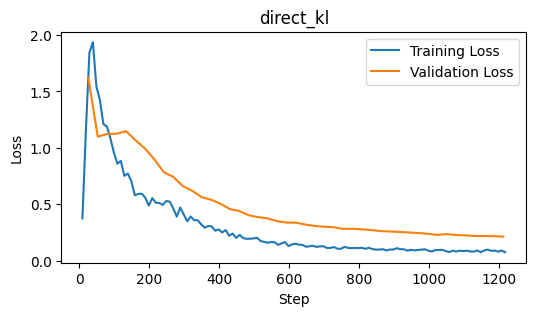

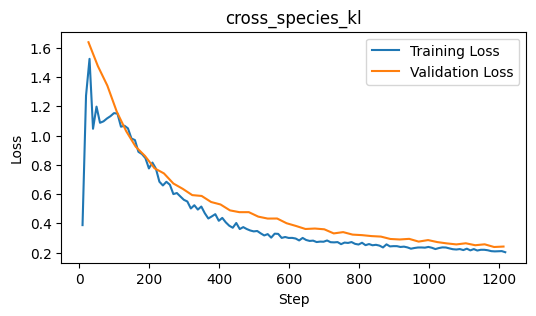

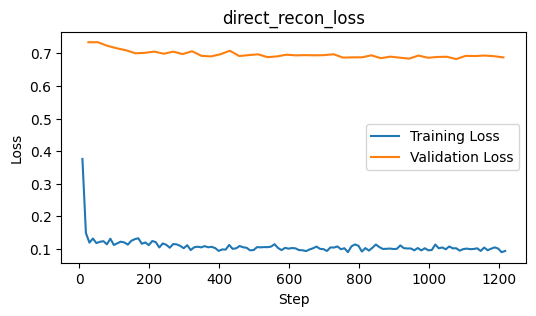

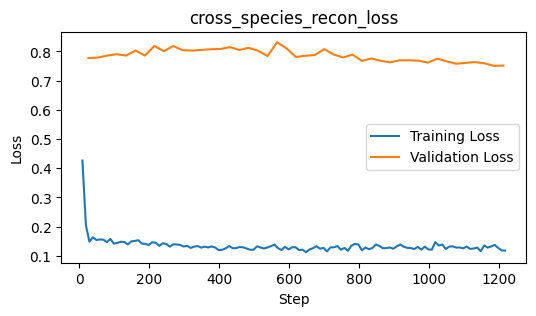

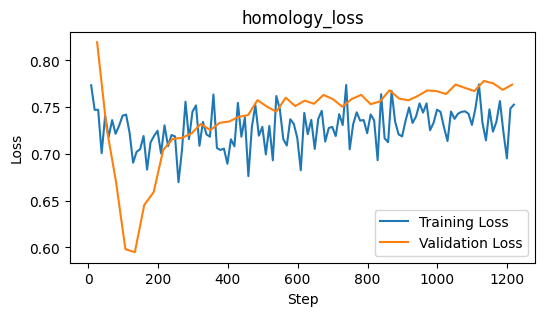

In [5]:
from tensorboard.backend.event_processing import event_accumulator

# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('lightning_logs/version_*')])
ea = event_accumulator.EventAccumulator(f'lightning_logs/version_{version}')
ea.Reload()  # Load all data

# Get list of available metrics
print(ea.scalars.Keys())

# Convert to pandas DataFrame
import pandas as pd

for loss_type in ["direct_kl", "cross_species_kl", "direct_recon_loss", "cross_species_recon_loss", "homology_loss"]:
    # Get specific metrics
    train_loss = pd.DataFrame(ea.Scalars(f'train_{loss_type}'), columns=['wall_time', 'step', 'value'])
    val_loss = pd.DataFrame(ea.Scalars(f'val_{loss_type}'), columns=['wall_time', 'step', 'value'])


    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_loss['step'], train_loss['value'], label='Training Loss')
    plt.plot(val_loss['step'], val_loss['value'], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()


In [15]:
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# Load the checkpoint
checkpoint = torch.load(best_model_path)

# Create a new model with the same hyperparameters and homology information
model = CrossSpeciesVAE(
    homology_edges=homology_edges,  # Need to pass these again
    **checkpoint['hyper_parameters']  # This loads all other hyperparameters
)

# Load the state dict
model.load_state_dict(checkpoint['state_dict'])

Best model path: /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints/crossspecies_vae-epoch=24-val_loss=1.51.ckpt
Scaled learning rate: 1.00e-03


/tmp/ipykernel_673298/1503692038.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


<All keys matched successfully>

In [6]:
output, s = model.get_latent_embeddings({"planarian": adata1,
                                         "schisto": adata2,
                                         "hydra": adata3,
}, reference_species=0)
s=s.cpu().numpy()

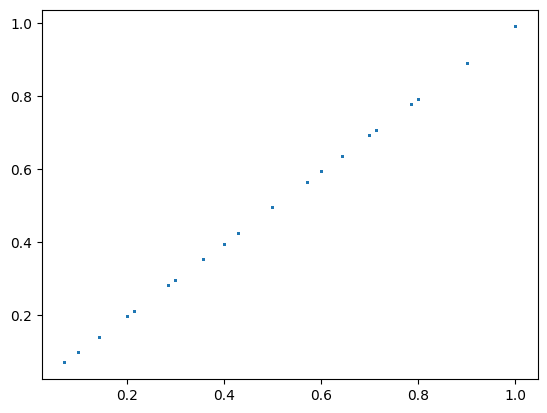

In [7]:
x=[]
y=[]
for i in range(len(set(s))):
    for j in range(i+1,len(set(s))):
        x.extend(homology_scores[i][j]/homology_scores[i][j].max())
        x.extend(homology_scores[j][i]/homology_scores[j][i].max())        
        y.extend(list(model.homology_scores[str(i)][str(j)].detach().cpu().numpy()))
        y.extend(list(model.homology_scores[str(j)][str(i)].detach().cpu().numpy()))
        
x=np.array(x)
y=np.array(y)
plt.figure(); plt.scatter(x,y,s=1);

In [8]:
import matplotlib.pyplot as plt
import umap

dt = umap.UMAP(n_components=2).fit_transform(output)


/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


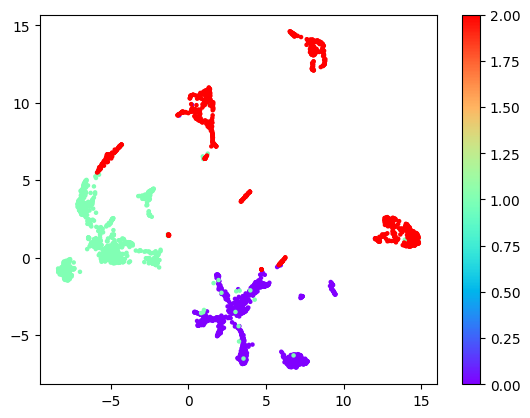

In [9]:
plt.figure();
plt.scatter(dt[:,0],dt[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()


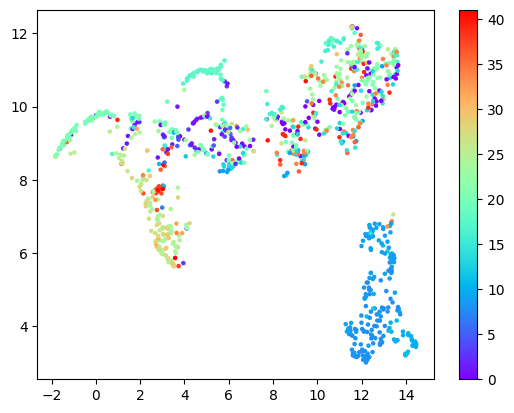

In [20]:
dt = umap.UMAP(n_components=2).fit_transform(output[s==0])
plt.figure();
plt.scatter(dt[:,0],dt[:,1], c = adata1.obs['cluster'].cat.codes,s=5, cmap='rainbow'); plt.colorbar()


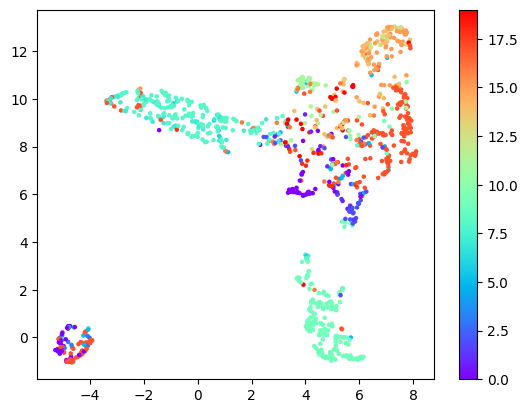

In [21]:
dt = umap.UMAP(n_components=2).fit_transform(output[s==1])
plt.figure();
plt.scatter(dt[:,0],dt[:,1], c = adata2.obs['cluster_t'].cat.codes,s=5, cmap='rainbow'); plt.colorbar()


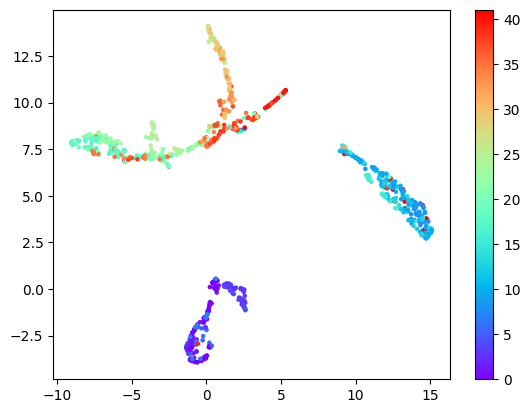

In [22]:
dt = umap.UMAP(n_components=2).fit_transform(output[s==2])
plt.figure();
plt.scatter(dt[:,0],dt[:,1], c = adata3.obs['Cluster'].cat.codes,s=5, cmap='rainbow'); plt.colorbar()


-0.06151691818473712
-0.05221527230489028
[3617]


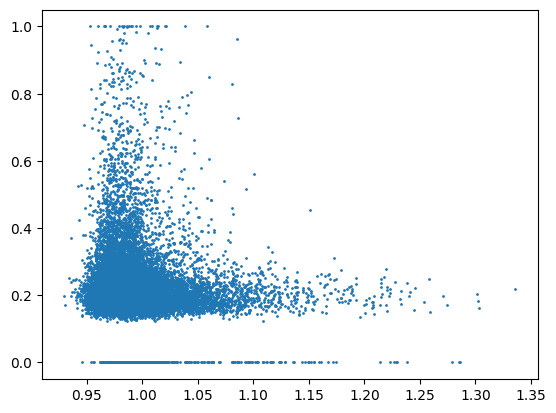

In [23]:
from scipy.stats import spearmanr

x = model.encoders['0'].gene_importance.global_weights.cpu().detach().numpy()

a = x
b = adata1.var['weights'].values

plt.figure(); plt.scatter(a,b,s=1);
print(np.corrcoef(a,b)[0,1])

print(spearmanr(a,b).statistic)
print(np.where(adata1.var_names[np.argsort(-x)]=='dd_Smed_v4_756_0_1')[0])

0.08723939804904492
0.20995899749241054


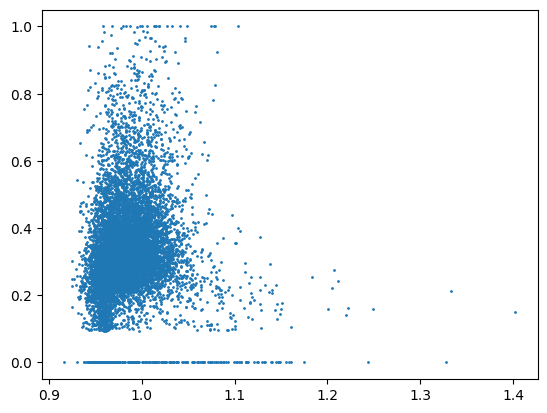

In [14]:
from scipy.stats import spearmanr

x = model.encoders['1'].gene_importance.global_weights.cpu().detach().numpy()

a = x
b = adata2.var['weights'].values

plt.figure(); plt.scatter(a,b,s=1);
print(np.corrcoef(a,b)[0,1])

print(spearmanr(a,b).statistic)

-0.005714136560819965
0.06372648187184081


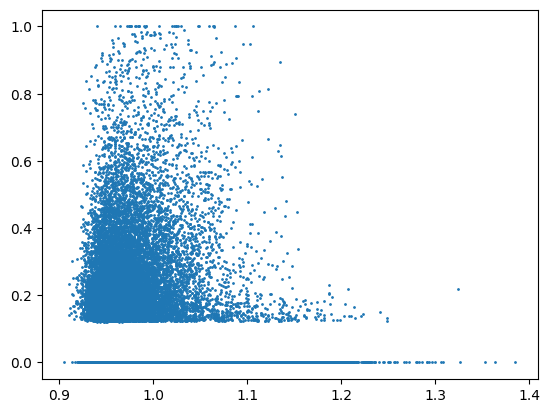

In [15]:
from scipy.stats import spearmanr

x = model.encoders['2'].gene_importance.global_weights.cpu().detach().numpy()

a = x
b = adata3.var['weights'].values

plt.figure(); plt.scatter(a,b,s=1);
print(np.corrcoef(a,b)[0,1])

print(spearmanr(a,b).statistic)

In [16]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [17]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [18]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))
c1 = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
c2 = c2[indices]

In [19]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [20]:
c2[:20]

array([['Intestine', 'Cathepsin', 'Neural', 'Cathepsin', 'Neural'],
       ['Neural', 'Intestine', 'Cathepsin', 'Flame cells', 'Muscle'],
       ['Flame cells', 'Neural', 'Muscle', 'Muscle', 'Intestine'],
       ['Neural', 'Neural', 'Cathepsin', 'Neural', 'Neural'],
       ['Muscle', 'Flame cells', 'Neural_KK7', 'Neural', 'Muscle'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Neural', 'Neural', 'Neural', 'Cathepsin', 'Parenchymal'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Neural', 'Muscle', 'Flame cells', 'Flame cells', 'Muscle'],
       ['Cathepsin', 'Muscle', 'Tegument', 'Gland', 'Tegument'],
       ['Intestine', 'Neural', 'Cathepsin', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Cathepsin', 'Neural', 'Neural'],
       ['Intestine', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Intestine', 'Cathepsin', 'Neur